In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import map_coordinates
# from skimage.registration import diffeomorphic_metric_mapping
from skimage.transform import resize, rescale

import requests
from io import BytesIO
import tifffile as tf
import nrrd

import seaborn as sns
sns.set_context('talk')

In [2]:
cd ..

/Users/TingshanLiu/Desktop/2020 fall/NDD


In [5]:
!ln -s scikit-image/skimage/registration/_lddmm.py _lddmm.py

In [6]:
!ln -s scikit-image/skimage/registration/_lddmm_utilities.py _lddmm_utilities.py

In [7]:
from _lddmm import diffeomorphic_metric_mapping

In [8]:
# Load reference_image.
reference_image_url = "http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/average_template/average_template_50.nrrd"
request = requests.get(reference_image_url)
byte_content = BytesIO(request.content)
header = nrrd.read_header(byte_content)
reference_image = nrrd.read_data(header, byte_content)
reference_image = reference_image.astype(float)


In [12]:
# Load moving_image.

# moving_image_url = "https://open-neurodata.s3.amazonaws.com/ailey/thy1eyfp_preprocessed_50um.tif"
# request = requests.get(moving_image_url)
# byte_content = BytesIO(request.content)
# moving_image = tf.imread(byte_content)
# moving_image = moving_image.astype(float)

In [13]:
# moving_image.shape

(223, 147, 265)

In [9]:
# m = moving_image.reshape(moving_image.shape[0], -1)
# np.savetxt("moving_image.txt", m)
m = np.loadtxt("moving_image.txt")
# m = m.reshape(m.shape[0], m.shape[1]//moving_image.shape[2], moving_image.shape[2])
moving_image = m.reshape(m.shape[0], m.shape[1]//265, 265)

In [10]:
# Reorient moving_image.
moving_image = np.moveaxis(
    moving_image, source=[0, 1, 2], destination=[2, 1, 0]
)
moving_image = np.flip(
    moving_image, 2
)  # This saggittal flip corrects inversion.

In [11]:
# Specify spacings.
reference_image_spacing = np.array([50, 50, 50])
moving_image_spacing = np.array([50, 50, 50])

In [12]:
# Learn registration from reference_image to moving_image.
lddmm_output = diffeomorphic_metric_mapping(
    reference_image=reference_image,
    moving_image=moving_image,
    reference_image_spacing=reference_image_spacing,
    moving_image_spacing=moving_image_spacing,
    deformative_stepsize=2e5,
    sigma_regularization=1e4,
    contrast_order=3,
    multiscales=[16, 8],
    num_iterations=[50, 100],
    num_affine_only_iterations=[50, 0],
    num_rigid_affine_iterations=[25, 0],
)

### Assessing the Registration

In [22]:
def generate_calibration_plots(
    affines,
    maximum_velocities,
    matching_energies,
    regularization_energies,
    total_energies,
):
    """
    Plot the energies, maximum velocities, translation components, and linear
    components as functions of the number of iterations.
    """

    fig, axs = plt.subplots(2, 2, figsize=(10, 15))

    # Plot matching, regularization, and total energies.
    ax = axs[0, 0]
    ax.plot(
        list(zip(matching_energies, regularization_energies, total_energies))
    )
    ax.set_title("Energies")

    # Plot the maximum velocity.
    ax = axs[0, 1]
    ax.plot(maximum_velocities)
    ax.set_title("Maximum\nvelocity")

    # Plot affine[:, :-1], the translation components.
    translations = [affine[:-1, -1] for affine in affines]
    ax = axs[1, 0]
    ax.plot(translations)
    ax.set_title("Translation\ncomponents")

    # Plot self.affine[:-1, :-1], the linear transformation components.
    linear_components = [affine[:-1, :-1].ravel() for affine in affines]
    ax = axs[1, 1]
    ax.plot(linear_components)
    ax.set_title("Linear\ncomponents")

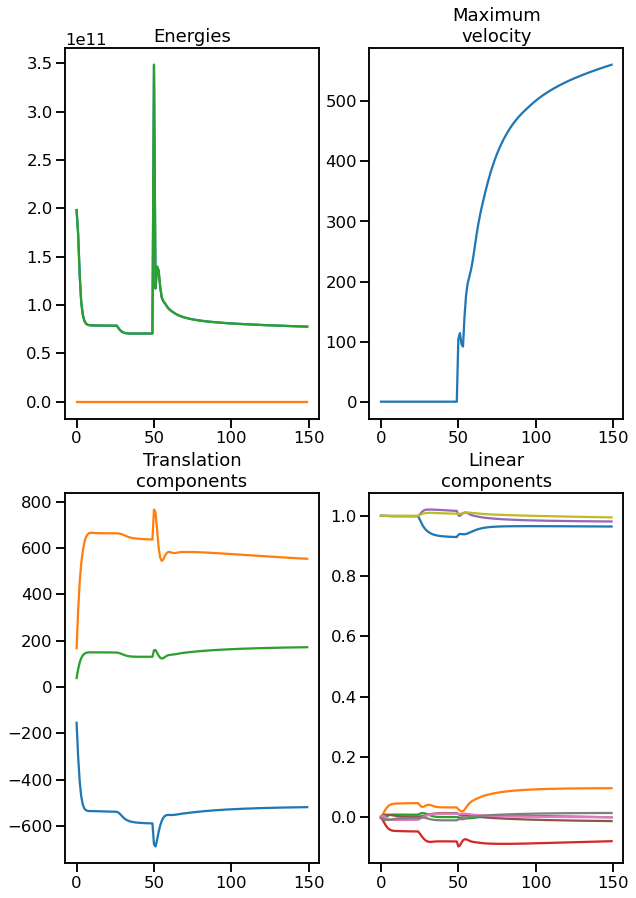

In [23]:
# Visualize registration progression, useful for parameter tuning.
generate_calibration_plots(
    affines=lddmm_output.diagnostics.affines,
    maximum_velocities=lddmm_output.diagnostics.maximum_velocities,
    matching_energies=lddmm_output.diagnostics.matching_energies,
    regularization_energies=lddmm_output.diagnostics.regularization_energies,
    total_energies=lddmm_output.diagnostics.total_energies,
)

### Apply Registration

In [24]:
apply = "at native spacing"
# apply = "to different images at native spacing"
# apply = "to different images at different spacing"


# Apply registration to reference_image and moving_image at native spacing.

if apply == "at native spacing":

    deformed_moving_image = map_coordinates(
        input=moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform,
    )

    deformed_reference_image = map_coordinates(
        input=reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform,
    )

    reference_image_vis = reference_image
    moving_image_vis = moving_image


# Apply to different images
# (mocked with rescaled versions of reference_image and moving_image)
# at native spacing.

elif apply == "to different images at native spacing":

    rescaled_reference_image = rescale(
        reference_image, np.pi
    )  # This could by any image in the reference_image space.
    rescaled_moving_image = rescale(
        moving_image, np.e
    )  # This could by any image in the moving_image space.

    reference_image_scale = np.divide(
        rescaled_reference_image.shape, reference_image.shape
    )
    moving_image_scale = np.divide(
        rescaled_moving_image.shape, moving_image.shape
    )

    deformed_moving_image = map_coordinates(
        input=rescaled_moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform
        * moving_image_scale[:, None, None, None],
    )

    deformed_reference_image = map_coordinates(
        input=rescaled_reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform
        * reference_image_scale[:, None, None, None],
    )

    reference_image_vis = reference_image
    moving_image_vis = moving_image


# Apply to different images

elif apply == "to different images at different spacing":

    rescaled_reference_image = rescale(reference_image, np.pi)
    rescaled_moving_image = rescale(moving_image, np.e)

    reference_image_scale = np.divide(
        rescaled_reference_image.shape, reference_image.shape
    )
    moving_image_scale = np.divide(
        rescaled_moving_image.shape, moving_image.shape
    )

    rescaled_moving_image_to_reference_image_transform = resize(
        lddmm_output.moving_image_to_reference_image_transform
        * moving_image_scale[:, None, None, None],
        (3, *rescaled_reference_image.shape),
    )
    rescaled_reference_image_to_moving_image_transform = resize(
        lddmm_output.reference_image_to_moving_image_transform
        * reference_image_scale[:, None, None, None],
        (3, *rescaled_moving_image.shape),
    )

    deformed_moving_image = map_coordinates(
        input=rescaled_moving_image,
        coordinates=rescaled_moving_image_to_reference_image_transform,
    )

    deformed_reference_image = map_coordinates(
        input=rescaled_reference_image,
        coordinates=rescaled_reference_image_to_moving_image_transform,
    )

    reference_image_vis = rescaled_reference_image
    moving_image_vis = rescaled_moving_image

### Visualize results

In [25]:
def scale_data(data, quantile_threshold=0.001):

    data = np.copy(data)

    lower_limit = np.quantile(
        data, min(quantile_threshold, 1 - quantile_threshold)
    )
    upper_limit = np.quantile(
        data, max(quantile_threshold, 1 - quantile_threshold)
    )
    data_range = upper_limit - lower_limit

    data -= lower_limit
    data /= data_range

    return data

In [26]:
def imshow_on_ax(
    axs, dim, column, image, overlaid_image=None, quantile_threshold=0.001
):
    ax = axs[dim, column]
    ax.axis("off")

    scaled_image = scale_data(image, quantile_threshold)

    display_image = scaled_image

    if overlaid_image is not None:
        scaled_overlaid_image = scale_data(overlaid_image, quantile_threshold)
        display_image = np.stack(
            [scaled_image, scaled_overlaid_image, scaled_image], axis=-1
        )

    ax.imshow(
        display_image.take(display_image.shape[dim] // 2, axis=dim),
        cmap="gray",
        vmin=0,
        vmax=1,
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


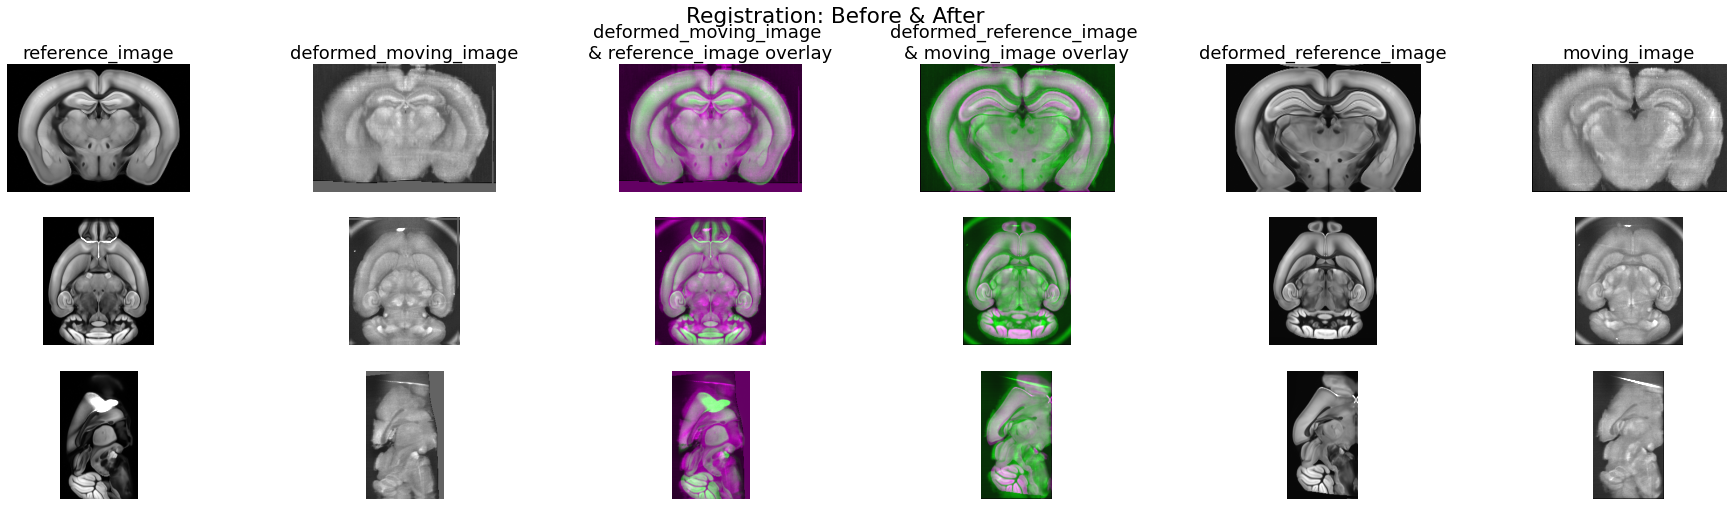

In [28]:
fig, axs = plt.subplots(3, 6, figsize=(32, 8))

fig.suptitle("Registration: Before & After")

# Call imshow for each subplot axs.
for dim in range(3):
    # vmin and vmax are set to saturate the top and bottom 0.1% extrema.

    # Column 0: raw reference_image.
    imshow_on_ax(axs=axs, dim=dim, column=0, image=reference_image_vis)

    # Column 1: deformed_moving_image.
    imshow_on_ax(axs=axs, dim=dim, column=1, image=deformed_moving_image)

    # Column 2: deformed_moving_image overlaid with reference_image.
    imshow_on_ax(
        axs=axs,
        dim=dim,
        column=2,
        image=deformed_moving_image,
        overlaid_image=reference_image_vis,
    )

    # Column 3: deformed_reference_image overlaid with moving_image.
    imshow_on_ax(
        axs=axs,
        dim=dim,
        column=3,
        image=deformed_reference_image,
        overlaid_image=moving_image_vis,
    )

    # Column 4: deformed_reference_image.
    imshow_on_ax(axs=axs, dim=dim, column=4, image=deformed_reference_image)

    # Column 5: raw moving_image.
    imshow_on_ax(axs=axs, dim=dim, column=5, image=moving_image_vis)


# Set column labels.
for ax, column_label in zip(
    axs[0],
    [
        "reference_image",
        "deformed_moving_image",
        "deformed_moving_image \n& reference_image overlay",
        "deformed_reference_image \n& moving_image overlay",
        "deformed_reference_image",
        "moving_image",
    ],
):
    ax.set_title(column_label)


# Set row labels.
for ax, row_index in zip(axs[:, 0], range(len(axs))):
    row_label = f"Dimension {row_index}"
    ax.set_ylabel(row_label, rotation="vertical")